# **Scraping**

Lets begin by extracting the data regarding musical instruments sold on Craigslist in the city of Charlottesville.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/msa?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url, headers=header)
bsObj = soup(raw.content, 'html.parser')


In [74]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Lets define the instrument categories and append to the dataset.

In [77]:
# Define instrument categories
instrument_list = ['guitar', 'piano', 'bass', 'keyboard', 'amp', 'ukulele', 'drum']

data = []  # Store listings
listings = bsObj.find_all(class_="cl-static-search-result")

for listing in listings:
    title = listing.find('div', class_='title').get_text().lower()
    price = listing.find('div', class_='price').get_text()
    link = listing.find(href=True)['href']

    # Identify instrument type from title
    hits = [word for word in instrument_list if word in title]  # Case-insensitive matching
    instrument_type = hits[0] if hits else 'missing'

    # Extract year from title
    regex_search = re.search(r'20[0-9]{2}|19[0-9]{2}', title)
    year = int(regex_search.group(0)) if regex_search else np.nan

    # Append to dataset
    data.append({'title': title, 'price': price, 'year': year, 'link': link, 'instrument': instrument_type})

DataFrame shape: (127, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       127 non-null    object 
 1   price       127 non-null    float64
 2   year        17 non-null     float64
 3   link        127 non-null    object 
 4   instrument  127 non-null    object 
 5   age         17 non-null     float64
dtypes: float64(3), object(3)
memory usage: 6.1+ KB
None


,title,price,year,link,instrument,age
0,"new casematix 16"" hard travel case",40.0,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
1,"line 6 flextone ii xl (2x12"",100 watt) w/foot ...",250.0,NaN,https://charlottesville.craigslist.org/msg/d/p...,missing,NaN
2,used drum equipment jackpot,5000.0,NaN,https://charlottesville.craigslist.org/msg/d/c...,drum,NaN
3,evh wolfgang standard,600.0,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
4,dean edge q5 5 string bass,250.0,NaN,https://charlottesville.craigslist.org/msg/d/p...,bass,NaN


In [78]:

# Convert to DataFrame
df = pd.DataFrame(data)

# Clean and convert price column
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Convert year to numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')

df['age'] = 2025 - df['year']
df.loc[df['year'].isna(), 'age'] = np.nan  # Ensure missing years have NaN age

# Display DataFrame info
print(f"DataFrame shape: {df.shape}")
print(df.info())
df.head()


DataFrame shape: (127, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       127 non-null    object 
 1   price       127 non-null    float64
 2   year        17 non-null     float64
 3   link        127 non-null    object 
 4   instrument  127 non-null    object 
 5   age         17 non-null     float64
dtypes: float64(3), object(3)
memory usage: 6.1+ KB
None


,title,price,year,link,instrument,age
0,"new casematix 16"" hard travel case",40.0,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
1,"line 6 flextone ii xl (2x12"",100 watt) w/foot ...",250.0,NaN,https://charlottesville.craigslist.org/msg/d/p...,missing,NaN
2,used drum equipment jackpot,5000.0,NaN,https://charlottesville.craigslist.org/msg/d/c...,drum,NaN
3,evh wolfgang standard,600.0,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
4,dean edge q5 5 string bass,250.0,NaN,https://charlottesville.craigslist.org/msg/d/p...,bass,NaN


Let's determine the average price by instrument

In [79]:
# Price by instrument:
df.loc[:,['price','instrument']].groupby('instrument').describe()

price                                                         \
           count         mean          std   min    25%    50%      75%   
instrument                                                                
amp          9.0   469.333333   777.026544  40.0  100.0  160.0   400.00   
bass         7.0   205.000000   274.104603  35.0   50.0   75.0   212.50   
drum         3.0  1758.333333  2808.728953  50.0  137.5  225.0  2612.50   
guitar      19.0   220.578947   412.483039   0.0   15.5   40.0   230.00   
missing     80.0   495.787500   572.776929   1.0  100.0  267.5   750.00   
piano        4.0   106.250000    77.392398   0.0   75.0  125.0   156.25   
ukulele      5.0    14.000000     8.944272   5.0    5.0   15.0    20.00   

                    
               max  
instrument          
amp         2500.0  
bass         800.0  
drum        5000.0  
guitar      1695.0  
missing     2800.0  
piano        175.0  
ukulele       25.0

Let's determine the average age by instrument

In [85]:
# Age by instrument
df.dropna(subset=['age', 'instrument']).loc[:, ['age', 'instrument']].groupby('instrument').describe()


age                                                      
           count       mean        std   min    25%   50%    75%   max
instrument                                                            
amp          1.0  49.000000        NaN  49.0  49.00  49.0  49.00  49.0
guitar       2.0  35.000000   5.656854  31.0  33.00  35.0  37.00  39.0
missing     14.0  37.928571  15.608007   7.0  25.25  44.0  48.75  55.0

Let's plot the correlation between price and age of the instrument

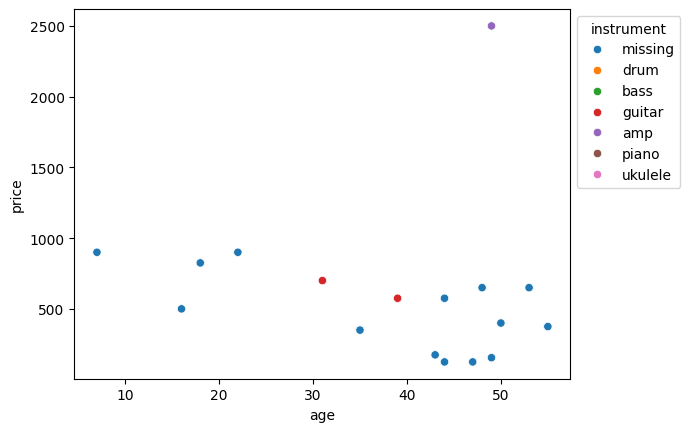

In [81]:

ax = sns.scatterplot(data=df, x='age', y='price',hue='instrument')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   2.780702 -0.149301
log_age    -0.149301  0.308958
           log_price   log_age
log_price   1.000000 -0.335131
log_age    -0.335131  1.000000


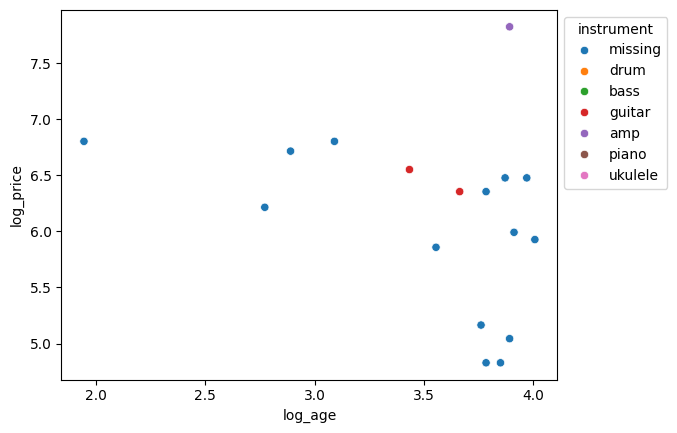

In [86]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='instrument')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

I am able to draw several conclutions from the data above. For one, when comparing the average price per instrument, it appears that drums have the highest prices and ukulele have the lowest prices. It also appears that price tends to decrease as the age tends to increase (negative correlation). This makes sense as older instruments tend to break/lose quality over time, which is why they are likely cheaper.